In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 6754, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 6754 (delta 167), reused 164 (delta 140), pack-reused 6557
Receiving objects: 100% (6754/6754), 2.96 GiB | 28.93 MiB/s, done.
Resolving deltas: 100% (5534/5534), done.
Updating files: 100% (521/521), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 26.3 MB/s eta 0:00:00


In [3]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 9.1 MB/s eta 0:00:00


In [4]:
# ! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

In [5]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
import scipy.stats as stats
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBRanker

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/ease_r_all.zip
/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/ease_r_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/mult_vae_2_all.zip
/kaggle/input/training-tuned-models/ease_r_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/__output__.json
/kaggle/input/training-tuned-models/ials_all.zip
/kaggle/input/training-tun

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender
from Recommenders.GraphBased.HHPRecommender import HHPRecommender
from Recommenders.GraphBased.TwoWayRankAggregationRecommender import TwoWayRankAggregationRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
config = {
    'tune_parameters': True,
    'n_trials': 35,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [11]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [12]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [13]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [21]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [22]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [23]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hhp.json', 'r') as params_file:
    params_hhp = json.load(params_file)
params_hhp

{'hybrid_lambda': 0.8450256587797654, 'topK': 61}

In [24]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_twra.json', 'r') as params_file:
    params = json.load(params_file)

params_twra = {
    'base_f_algorithm': params['base_f_algorithm'], 
    'base_b_algorithm': params['base_b_algorithm'], 
    'convex_lambda': params['convex_lambda'],
}

if params['base_f_algorithm'] == 'p3':
    params_twra['f_params'] = {
        'topK': params['f_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'p3alpha':
    params_twra['f_params'] = {
        'alpha': params['f_p3a_alpha'],
        'topK': params['f_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'rp3beta':
    params_twra['f_params'] = {
        'alpha': params['f_rp3_alpha'],
        'beta': params['f_rp3_beta'],
        'topK': params['f_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['f_params'] = {
        'hybrid_lambda': params['f_hhp_hybrid_lambda'],
        'topK': params['f_hhp_topK'],
    }

if params['base_b_algorithm'] == 'p3':
    params_twra['b_params'] = {
        'topK': params['b_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'p3alpha':
    params_twra['b_params'] = {
        'alpha': params['b_p3a_alpha'],
        'topK': params['b_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'rp3beta':
    params_twra['b_params'] = {
        'alpha': params['b_rp3_alpha'],
        'beta': params['b_rp3_beta'],
        'topK': params['b_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['b_params'] = {
        'hybrid_lambda': params['b_hhp_hybrid_lambda'],
        'topK': params['b_hhp_topK'],
    }

In [25]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_rp3_recall@50.json', 'r') as params_file:
    params_rp3_recall = json.load(params_file)
params_rp3_recall

{'alpha': 0.2139985499567939, 'beta': 0.2194371742883361, 'topK': 154}

In [26]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_item_knn_recall@50.json', 'r') as params_file:
    params_item_knn_recall = json.load(params_file)
params_item_knn_recall

{'topK': 62,
 'shrink': 480,
 'similarity': 'tversky',
 'feature_weighting': 'BM25',
 'tversky_alpha': 0.03679620043176055,
 'tversky_beta': 1.9314395554791928}

In [27]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip', 
    '/kaggle/working/slim_recall_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_train_validation.zip', 
    '/kaggle/working/slim_recall_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_all.zip', 
    '/kaggle/working/slim_recall_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip', 
    '/kaggle/working/mult_vae_2_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip', 
    '/kaggle/working/mult_vae_2_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_all.zip', 
    '/kaggle/working/mult_vae_2_all.zip', 
)

'/kaggle/working/mult_vae_2_all.zip'

In [28]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_train = recommender_pure_svd.USER_factors
item_factors_train = recommender_pure_svd.ITEM_factors

# recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
# recommender_scaled_svd.fit(**params_scaled)

# recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
# recommender_pure_svd_item.fit(**params_pure_svd_item)

# recommender_nmf = NMFRecommender(URM_train)
# recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

# recommender_slim_bpr = SLIM_BPR_Python(URM_train)
# recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_xgboost_train_validation')

recommender_hhp = HHPRecommender(URM_train)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train)
# recommender_als.load_model('/kaggle/working/', 'als_xgboost_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_xgboost_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train)
recommender_item_recall.fit(**params_item_knn)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 2444.25 column/sec. Elapsed time 9.14 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1544.22 column/sec. Elapsed time 8.43 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 5091.25 column/sec. Elapsed time 4.39 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity colum

In [29]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions


In [30]:
cutoff = 50
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    if user_id == 0:
        print(recommendations)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_19/2461008040.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

[   0    1    2    3    9   28   35   53   57   75   76   84   86   97
  100  101  111  122  136  138  155  170  215  253  256  283  288  336
  341  366  385  402  428  485  492  505  514  533  591  617  636  693
  699  715  772  849  868  921  976 1056 1067 1082 1088 1131 1213 1257
 1287 1337 1421 1480 1489 1514 1545 1629 1744 1813 1913 1934 2002 2011
 2480 2498 2539 2724 2781 3156 3315 3728 4499 4749 6222 8500]


,ItemID
UserID,
0,0
0,1
0,2
0,3
0,9
...,...
13023,15027
13023,15028
13023,15668


In [31]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [32]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,0,False
1,0,1,False
2,0,2,False
3,0,3,False
4,0,9,False
...,...,...,...
1196652,13023,15027,False
1196653,13023,15028,False
1196654,13023,15668,False
1196655,13023,20107,False


In [33]:
training_dataframe.Label.sum()

20619

In [34]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
#     'NMF': recommender_nmf,
#     'PureSVD': recommender_pure_svd,
#     'ScaledSVD': recommender_scaled_svd,
#     'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
#     'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [35]:
tmp = training_dataframe[training_dataframe['UserID'] == 0].copy()

scores = recommender_item._compute_item_score([0])
linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
linf_scores[0, :] = recommender_item._remove_seen_on_scores(0, linf_scores[0, :])
linf_scores

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
rank = np.argsort(linf_scores[0, :])[::-1]
rank[:50]

array([  35,  100,  505,  591,  693, 1480,  402,  617,  341,  122, 1421,
       1545,  428, 1082, 1287, 1337, 1213, 1088,  170,  138,  253, 1131,
       3156, 1056,  215, 3728,  514,  101, 2724, 1629,  485, 1913, 1257,
        772,   75, 4499,  385, 2539,  492,  636, 4749, 1934, 2480,  849,
       1813,  155, 2002, 1514,  976,  699])

In [37]:
tmp.ItemID.values.astype(int)

array([   0,    1,    2,    3,    9,   28,   35,   53,   57,   75,   76,
         84,   86,   97,  100,  101,  111,  122,  136,  138,  155,  170,
        215,  253,  256,  283,  288,  336,  341,  366,  385,  402,  428,
        485,  492,  505,  514,  533,  591,  617,  636,  693,  699,  715,
        772,  849,  868,  921,  976, 1056, 1067, 1082, 1088, 1131, 1213,
       1257, 1287, 1337, 1421, 1480, 1489, 1514, 1545, 1629, 1744, 1813,
       1913, 1934, 2002, 2011, 2480, 2498, 2539, 2724, 2781, 3156, 3315,
       3728, 4499, 4749, 6222, 8500])

In [38]:
item_list = tmp.ItemID.values.astype(int)

positions = np.zeros(n_items, dtype=int)
positions[rank] = np.arange(n_items)
positions[item_list]

array([21981,  7491,  7492,  7493,  7498,  7473,     0,  7540,  7544,
          34,  7519,  7527,  7529,  7410,     1,    27,    50,     9,
        7423,    19,    45,    18,    24,    20,  7687,  7584,  7589,
        7637,     8,  7146,    36,     6,    12,    30,    38,     2,
          26,  7087,     3,     7,    39,     4,    49,  7261,    33,
          43,  8148,    60,    48,    23,  8297,    13,    17,    21,
          16,    32,    14,    15,    10,     5,  6152,    47,    11,
          29,    66,    44,    31,    41,    46,  5951,    42,  6456,
          37,    28,    58,    22,    67,    25,    35,    40,    62,
        4623])

In [39]:
recommended = np.isin(item_list, rank[:10], assume_unique=True)
recommended.astype(int)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
training_dataframe = training_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        training_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        training_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        training_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()

item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

# todo: cluster if possible the similarity matrix of KNN or RP3, then add for each users some features 
# that represent something like users that like only items from the same cluster (e.g. items variability)
# same can be done with users and items reversed (i.e. using User KNN)

recommended_columns = [col for col in training_dataframe.columns if col.endswith('_Recommended')]
training_dataframe['Counter_Recommended'] = training_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in training_dataframe.columns if col.endswith('_RankPosition')]
training_dataframe['Mean_RankPosition'] = training_dataframe[position_columns].mean(axis=1)
training_dataframe['Std_RankPosition'] = training_dataframe[position_columns].std(axis=1)
training_dataframe['Skew_RankPosition'] = training_dataframe[position_columns].skew(axis=1)
training_dataframe['Kurtosis_RankPosition'] = training_dataframe[position_columns].kurtosis(axis=1)

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/223847650.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
/tmp/ipykernel_19/223847650.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,MaxSimilarityToSeenRP3,MinSimilarityToSeenRP3,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition
0,0,0,False,0.000000,21981.0,0.0,0.046025,50.0,0.0,0.172726,...,0.000000,0.0,0.000000,NaN,NaN,0,2239.6,6936.502820,3.162138,9.999350
1,0,1,False,0.000000,7491.0,0.0,0.045999,51.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,3600.8,4656.295471,0.854885,-0.806174
2,0,2,False,0.000000,7492.0,0.0,0.102911,4.0,1.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,2,4276.5,4688.592569,0.402352,-1.434449
3,0,3,False,0.000000,7493.0,0.0,0.071723,12.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,4121.5,4411.369005,0.207081,-2.031058
4,0,9,False,0.000000,7498.0,0.0,0.094539,5.0,1.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,1,3040.2,3866.053423,0.484167,-2.275425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196652,13023,15027,False,0.116225,38.0,0.0,0.069694,449.0,0.0,0.000000,...,0.032752,0.0,0.009631,2.527193,4.413497,0,4590.6,9051.548194,1.774078,1.396626
1196653,13023,15028,False,0.000000,21756.0,0.0,0.108215,196.0,0.0,0.000000,...,0.024615,0.0,0.003590,6.559137,41.022255,0,6789.0,10318.436574,1.033809,-1.225066
1196654,13023,15668,False,0.112155,40.0,0.0,0.056786,675.0,0.0,0.035712,...,0.029363,0.0,0.005710,4.496439,18.280294,0,2364.0,6250.280065,3.148655,9.936217
1196655,13023,20107,False,0.099075,45.0,0.0,0.056417,694.0,0.0,0.035768,...,0.043723,0.0,0.010818,3.013967,7.255245,0,392.1,414.750112,1.324460,0.478996


In [41]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
item_popularity = item_popularity / np.max(item_popularity)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
user_popularity = user_popularity / np.max(user_popularity)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len,mainstream_user,mainstream_item
0,0,0,False,0.000000,21981.0,0.0,0.046025,50.0,0.0,0.172726,...,NaN,0,2239.6,6936.502820,3.162138,9.999350,0.886424,0.033573,77.384713,64.370937
1,0,1,False,0.000000,7491.0,0.0,0.045999,51.0,0.0,0.000000,...,NaN,0,3600.8,4656.295471,0.854885,-0.806174,1.000000,0.033573,77.384713,62.304556
2,0,2,False,0.000000,7492.0,0.0,0.102911,4.0,1.0,0.000000,...,NaN,2,4276.5,4688.592569,0.402352,-1.434449,0.816327,0.033573,77.384713,66.387950
3,0,3,False,0.000000,7493.0,0.0,0.071723,12.0,0.0,0.000000,...,NaN,0,4121.5,4411.369005,0.207081,-2.031058,0.988465,0.033573,77.384713,68.811732
4,0,9,False,0.000000,7498.0,0.0,0.094539,5.0,1.0,0.000000,...,NaN,1,3040.2,3866.053423,0.484167,-2.275425,0.507542,0.033573,77.384713,58.666614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196652,13023,15027,False,0.116225,38.0,0.0,0.069694,449.0,0.0,0.000000,...,4.413497,0,4590.6,9051.548194,1.774078,1.396626,0.002662,0.055156,53.265190,488.276579
1196653,13023,15028,False,0.000000,21756.0,0.0,0.108215,196.0,0.0,0.000000,...,41.022255,0,6789.0,10318.436574,1.033809,-1.225066,0.004437,0.055156,53.265190,174.590408
1196654,13023,15668,False,0.112155,40.0,0.0,0.056786,675.0,0.0,0.035712,...,18.280294,0,2364.0,6250.280065,3.148655,9.936217,0.004437,0.055156,53.265190,418.908873
1196655,13023,20107,False,0.099075,45.0,0.0,0.056417,694.0,0.0,0.035768,...,7.255245,0,392.1,414.750112,1.324460,0.478996,0.002662,0.055156,53.265190,439.629097


In [42]:
user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])

training_dataframe = training_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
training_dataframe = training_dataframe.sort_values(by='UserID')
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,False,0.000000,21981.0,0.0,0.046025,50.0,0.0,0.172726,...,0.163921,0.090707,-0.216788,-0.041741,0.056197,0.005684,-0.001896,0.008995,-0.013853,-0.002147
59,0,1480,False,0.425462,5.0,1.0,0.043927,59.0,0.0,0.207495,...,0.011214,-0.004518,0.009050,-0.011515,0.008412,0.005684,-0.001896,0.008995,-0.013853,-0.002147
58,0,1421,False,0.273926,10.0,0.0,0.016866,438.0,0.0,0.137874,...,0.008304,-0.000813,0.007862,-0.005303,0.004007,0.005684,-0.001896,0.008995,-0.013853,-0.002147
57,0,1337,False,0.217530,15.0,0.0,0.015550,495.0,0.0,0.097859,...,0.007159,-0.012959,0.016733,0.007981,0.040655,0.005684,-0.001896,0.008995,-0.013853,-0.002147
56,0,1287,False,0.228756,14.0,0.0,0.019282,351.0,0.0,0.125857,...,0.008537,-0.009985,0.006478,0.003883,-0.011649,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196597,13023,732,False,0.288187,7.0,1.0,0.386797,2.0,1.0,0.220186,...,0.014192,-0.031852,0.012810,0.008754,0.044532,0.006896,-0.007143,0.001571,0.006195,0.023549
1196594,13023,623,False,0.143302,23.0,0.0,0.130632,131.0,0.0,0.137036,...,0.010742,-0.023307,-0.001427,0.002284,0.010152,0.006896,-0.007143,0.001571,0.006195,0.023549
1196611,13023,1239,False,0.082585,63.0,0.0,0.243267,32.0,0.0,0.066038,...,0.009043,-0.018530,0.014343,0.010199,0.040514,0.006896,-0.007143,0.001571,0.006195,0.023549
1196600,13023,827,False,0.121454,36.0,0.0,0.074460,414.0,0.0,0.066689,...,0.009000,-0.019473,0.002613,-0.002867,0.001220,0.006896,-0.007143,0.001571,0.006195,0.023549


In [43]:
n_estimators = 500
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 32
grow_policy = "depthwise"
objective = "map"  #"pairwise", "ndcg"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(
    objective='rank:{}'.format(objective),
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    max_leaves = int(max_leaves),
    grow_policy = grow_policy,
    verbosity = 1, # 2 if self.verbose else 0,
    booster = booster,
    # enable_categorical = True
)

In [44]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([ 82,  79,  88, ..., 113,  84,  85])

In [45]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])
# X_train["UserID"] = X_train["UserID"].astype("category")
# X_train["ItemID"] = X_train["ItemID"].astype("category")
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

# object_columns = X_train.select_dtypes(include=['object']).columns
# X_train[object_columns] = X_train[object_columns].astype('category')

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=32, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=500,
          n_jobs=None, num_parallel_tree=None, objective='rank:map', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

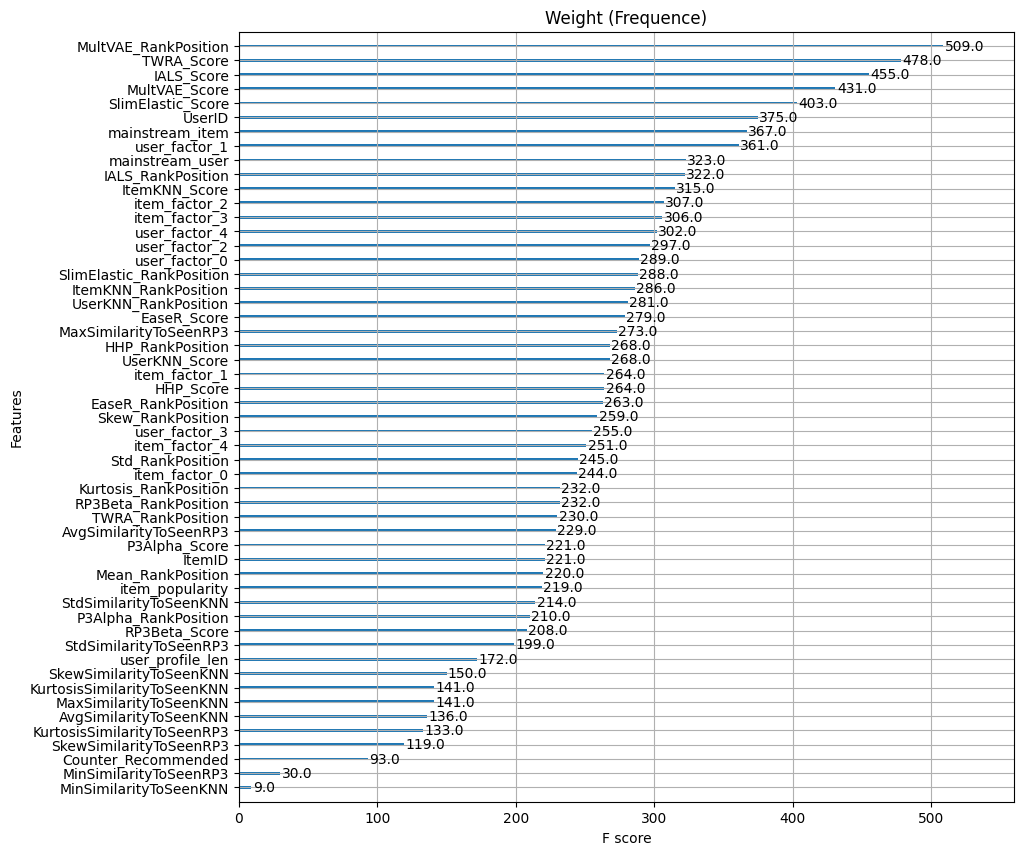

In [46]:
from xgboost import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)', ax=ax)

<Axes: title={'center': 'Feature Importance (Cover)'}, xlabel='F score', ylabel='Features'>

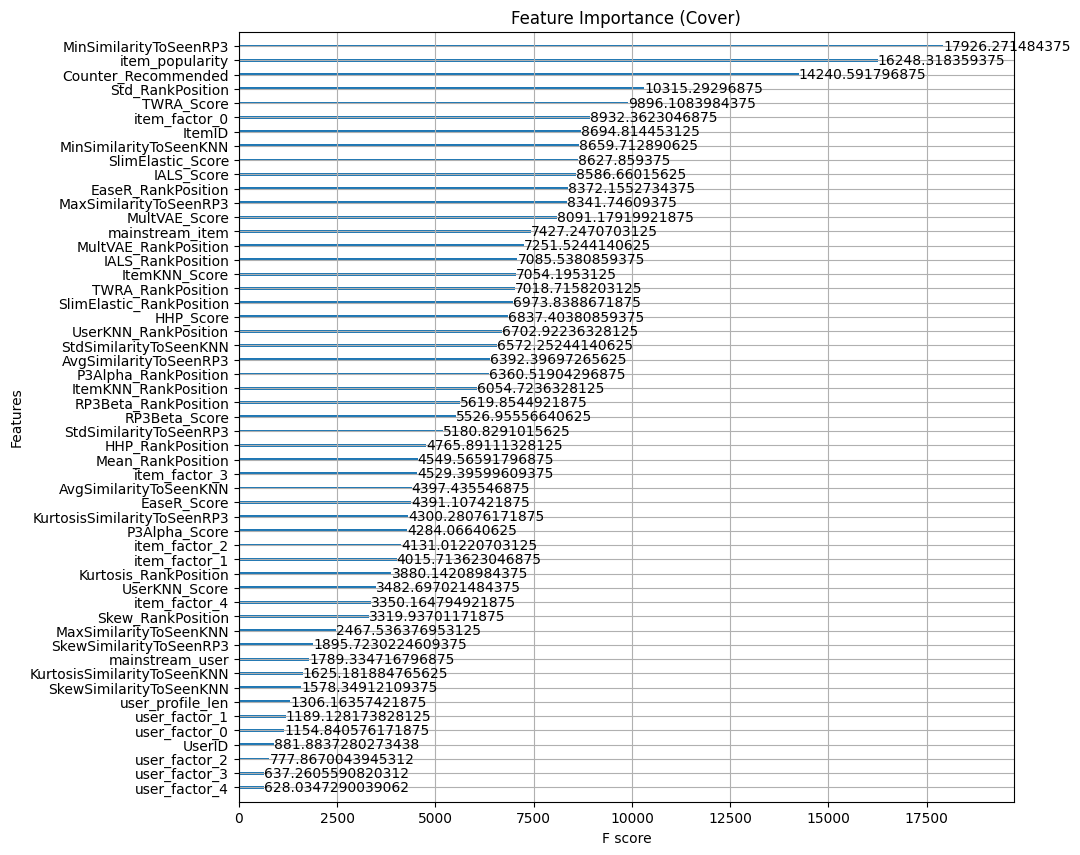

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='cover', title='Feature Importance (Cover)', ax=ax)

<Axes: title={'center': 'Feature Importance (Gain)'}, xlabel='F score', ylabel='Features'>

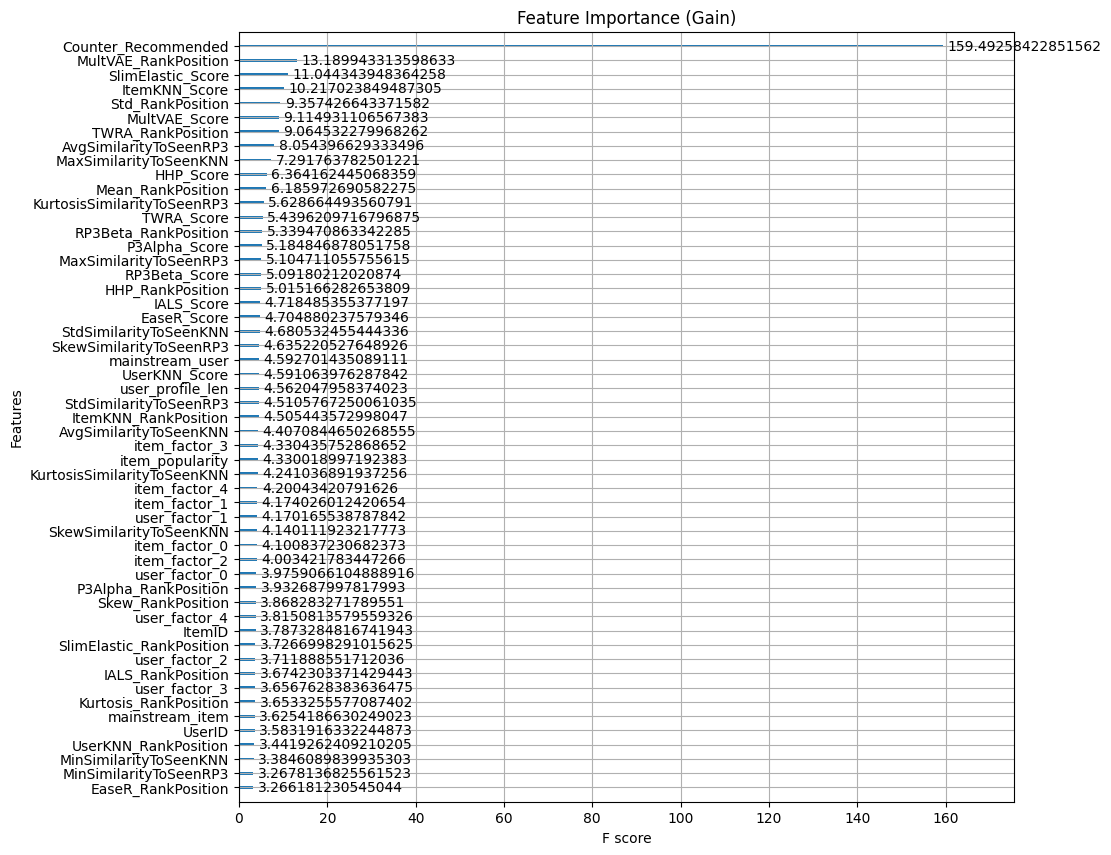

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='gain', title='Feature Importance (Gain)', ax=ax)

In [49]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

# recommender_pure_svd = PureSVDRecommender(URM_train_complete)
# recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

# recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
# recommender_scaled_svd.fit(**params_scaled)

# recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
# recommender_pure_svd_item.fit(**params_pure_svd_item)

# recommender_nmf = NMFRecommender(URM_train_complete)
# recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

# recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
# recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train_complete)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train_complete)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train_complete)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train_complete)
recommender_item_recall.fit(**params_item_knn)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 2298.56 column/sec. Elapsed time 9.72 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1393.64 column/sec. Elapsed time 9.35 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 4482.24 column/sec. Elapsed time 4.99 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity colum

In [50]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
#     'NMF': recommender_nmf,
#     'PureSVD': recommender_pure_svd,
#     'ScaledSVD': recommender_scaled_svd,
#     'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
#     'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [51]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.auto.tqdm(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        validation_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        validation_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        validation_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()
    
validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in validation_dataframe.columns if col.endswith('_Recommended')]
validation_dataframe['Counter_Recommended'] = validation_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in validation_dataframe.columns if col.endswith('_RankPosition')]
validation_dataframe['Mean_RankPosition'] = validation_dataframe[position_columns].mean(axis=1)
validation_dataframe['Std_RankPosition'] = validation_dataframe[position_columns].std(axis=1)
validation_dataframe['Skew_RankPosition'] = validation_dataframe[position_columns].skew(axis=1)
validation_dataframe['Kurtosis_RankPosition'] = validation_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len
0,0,0,0.000000,22282.0,0.0,0.049929,89.0,0.0,0.000000,22283.0,...,0.000000,NaN,NaN,0,6725.0,10726.657696,1.035071,-1.224485,0.886121,0.032075
1,0,1,0.000000,7496.0,0.0,0.090336,15.0,0.0,0.000000,7477.0,...,0.000000,NaN,NaN,0,3082.9,3821.952190,0.482605,-2.274253,1.000000,0.032075
2,0,2,0.000000,7497.0,0.0,0.095367,13.0,0.0,0.000000,7478.0,...,0.000000,NaN,NaN,0,3947.6,4136.405665,0.051490,-2.451839,0.811388,0.032075
3,0,3,0.000000,7498.0,0.0,0.114379,6.0,1.0,0.000000,7479.0,...,0.000000,NaN,NaN,1,4102.6,4378.702832,0.187281,-2.088190,0.973665,0.032075
4,0,7,0.189751,24.0,0.0,0.075345,28.0,0.0,0.113997,12.0,...,0.000000,NaN,NaN,0,27.4,12.438292,0.711533,-0.123813,0.692527,0.032075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160066,13023,11955,0.260745,15.0,0.0,0.157063,126.0,0.0,0.138857,32.0,...,0.014879,2.872438,6.805297,0,40.6,33.483661,2.172849,5.169136,0.004982,0.056604
1160067,13023,13474,0.133842,40.0,0.0,0.080531,372.0,0.0,0.038993,120.0,...,0.009683,3.538551,10.568274,0,170.7,121.227106,0.915364,-0.206255,0.005694,0.056604
1160068,13023,13592,0.324246,9.0,1.0,0.085230,341.0,0.0,0.202384,18.0,...,0.018326,2.426400,4.940655,1,73.5,117.567238,1.924935,2.524763,0.003559,0.056604
1160069,13023,20107,0.117283,44.0,0.0,0.055870,770.0,0.0,0.000000,15603.0,...,0.010866,2.507360,5.053177,0,2070.9,4820.925947,3.013333,9.245318,0.002847,0.056604


In [52]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])
validation_dataframe = validation_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe = validation_dataframe.sort_values(by='UserID')

validation_dataframe

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,0.000000,22282.0,0.0,0.049929,89.0,0.0,0.000000,22283.0,...,0.163921,0.090707,-0.216788,-0.041741,0.056197,0.005684,-0.001896,0.008995,-0.013853,-0.002147
61,0,1421,0.315619,13.0,0.0,0.038471,136.0,0.0,0.113535,13.0,...,0.008304,-0.000813,0.007862,-0.005303,0.004007,0.005684,-0.001896,0.008995,-0.013853,-0.002147
60,0,1337,0.256143,15.0,0.0,0.024642,334.0,0.0,0.077940,33.0,...,0.007159,-0.012959,0.016733,0.007981,0.040655,0.005684,-0.001896,0.008995,-0.013853,-0.002147
58,0,1213,0.219015,17.0,0.0,0.035522,166.0,0.0,0.086829,25.0,...,0.007796,-0.009614,0.002953,-0.000483,-0.004862,0.005684,-0.001896,0.008995,-0.013853,-0.002147
57,0,1131,0.134693,40.0,0.0,0.000000,9769.0,0.0,0.000000,7813.0,...,0.008328,-0.008771,0.024645,0.012543,0.037796,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160027,13023,695,0.000000,7231.0,0.0,0.357792,15.0,0.0,0.000000,7257.0,...,0.011910,-0.020622,0.017123,0.012590,0.042566,0.006896,-0.007143,0.001571,0.006195,0.023549
1160024,13023,562,0.000000,7107.0,0.0,0.320286,22.0,0.0,0.000000,7304.0,...,0.016861,-0.024979,0.033671,0.028157,0.060212,0.006896,-0.007143,0.001571,0.006195,0.023549
1160023,13023,473,0.119352,43.0,0.0,0.335018,20.0,0.0,0.062268,69.0,...,0.018639,-0.017509,0.038689,0.037094,0.052088,0.006896,-0.007143,0.001571,0.006195,0.023549
1160040,13023,1775,0.522397,2.0,1.0,0.408252,5.0,1.0,0.584994,2.0,...,0.008148,-0.024127,0.008053,0.003610,0.029769,0.006896,-0.007143,0.001571,0.006195,0.023549


In [53]:
# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

# object_columns = validation_dataframe.select_dtypes(include=['object']).columns
# validation_dataframe[object_columns] = validation_dataframe[object_columns].astype('category')

In [54]:
class XGBoostRerankerRecommender:
    def __init__(self, URM_train, XGB_model, df):
        self.URM_train = URM_train
        self.df = df
        self.XGB_model = XGB_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.XGB_model.predict(df_slice)
            recommendations.append(items[np.argsort(preds)[-cutoff:][::-1]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [55]:
recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 2.05 min. Users per second: 85


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.100277,0.174594,0.147393,0.050063,0.084595,0.274181,0.154981,0.119354,0.542081,0.36531,...,0.802826,0.435197,0.802826,0.054869,10.024487,0.996703,0.158319,0.772247,2.106303,0.29343


In [56]:
def objective_xgboost(trial):

    XGB_model = XGBRanker(
        objective = trial.suggest_categorical('objective', ["rank:map", "rank:pairwise", "rank:ndcg"]),
        n_estimators = trial.suggest_int('n_estimators', 10, 5000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 20),
        max_leaves = trial.suggest_int('max_leaves', 8, 1024),
        grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        verbosity = 2,
        booster = 'gbtree',
        # tree_method = trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        tree_method = 'hist',
        gamma = trial.suggest_float('gamma', 1e-7, 10, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-7, 1, log=True),
        subsample = trial.suggest_float('subsample', 0.1, 0.9),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9),
        # enable_categorical = True
    )
    
    XGB_model.fit(
        X_train,
        y_train,
        group=groups,
        verbose=True
    )
    
    recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
        
    return result_df.loc[10, 'MAP']

In [57]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_xgboost_only_best.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [58]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='tuning', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=config['n_trials'])

[I 2023-12-30 11:23:53,919] Using an existing study with name 'tuning' instead of creating a new one.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.76 min. Users per second: 46


[I 2023-12-30 11:43:36,873] Trial 35 finished with value: 0.05248036367058971 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4630, 'learning_rate': 0.00312337804892229, 'reg_alpha': 0.0017835100229089379, 'reg_lambda': 0.012960912974293932, 'max_depth': 6, 'max_leaves': 52, 'grow_policy': 'lossguide', 'gamma': 3.958469943319463e-06, 'min_child_weight': 0.31958096194569635, 'subsample': 0.10588101321494214, 'colsample_bytree': 0.4188561224734551}. Best is trial 33 with value: 0.052945381098116674.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.06 min. Users per second: 57


[I 2023-12-30 12:01:00,094] Trial 36 finished with value: 0.041726968490788864 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4995, 'learning_rate': 0.06276188427876037, 'reg_alpha': 0.00032416326569085385, 'reg_lambda': 0.0028677963456992723, 'max_depth': 4, 'max_leaves': 214, 'grow_policy': 'lossguide', 'gamma': 3.437175342956561e-07, 'min_child_weight': 0.41253956873926273, 'subsample': 0.2047457000886026, 'colsample_bytree': 0.3264876753617926}. Best is trial 33 with value: 0.052945381098116674.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.32 min. Users per second: 52


[I 2023-12-30 12:15:02,780] Trial 37 finished with value: 0.04857231285143532 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 3179, 'learning_rate': 0.010671712754768227, 'reg_alpha': 5.9342731020629726e-05, 'reg_lambda': 0.006615258016135945, 'max_depth': 6, 'max_leaves': 264, 'grow_policy': 'lossguide', 'gamma': 2.7239291921717074e-06, 'min_child_weight': 0.11896063173765685, 'subsample': 0.23574284422407957, 'colsample_bytree': 0.5033976647980918}. Best is trial 33 with value: 0.052945381098116674.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.81 min. Users per second: 62


[I 2023-12-30 12:23:02,733] Trial 38 finished with value: 0.034622879246062346 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1263, 'learning_rate': 0.06586286355798326, 'reg_alpha': 0.002065743116744183, 'reg_lambda': 0.0018490676984418701, 'max_depth': 8, 'max_leaves': 86, 'grow_policy': 'lossguide', 'gamma': 2.11125254958495e-05, 'min_child_weight': 0.04316428698854594, 'subsample': 0.16630101026325816, 'colsample_bytree': 0.37566969075524215}. Best is trial 33 with value: 0.052945381098116674.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.29 min. Users per second: 76


[I 2023-12-30 12:29:59,938] Trial 39 finished with value: 0.05146746077288387 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 1628, 'learning_rate': 0.027706084701430485, 'reg_alpha': 0.004699079155013216, 'reg_lambda': 0.15924915486314734, 'max_depth': 4, 'max_leaves': 169, 'grow_policy': 'lossguide', 'gamma': 2.866774747785226e-07, 'min_child_weight': 0.5072167541605199, 'subsample': 0.27597686202360733, 'colsample_bytree': 0.35094400984368146}. Best is trial 33 with value: 0.052945381098116674.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.76 min. Users per second: 46


[I 2023-12-30 12:45:03,949] Trial 40 finished with value: 0.04680849303506197 and parameters: {'objective': 'rank:map', 'n_estimators': 3097, 'learning_rate': 0.00970373938117219, 'reg_alpha': 0.0003669709210550278, 'reg_lambda': 0.016542545179131937, 'max_depth': 7, 'max_leaves': 381, 'grow_policy': 'lossguide', 'gamma': 2.5181315137753875e-06, 'min_child_weight': 0.18299587932912761, 'subsample': 0.21956734952971965, 'colsample_bytree': 0.43626298991612106}. Best is trial 33 with value: 0.052945381098116674.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.49 min. Users per second: 70


[I 2023-12-30 12:57:37,779] Trial 41 finished with value: 0.052794298253604606 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3834, 'learning_rate': 0.007864331976491482, 'reg_alpha': 0.0010718946059716482, 'reg_lambda': 0.028860298087110835, 'max_depth': 3, 'max_leaves': 463, 'grow_policy': 'lossguide', 'gamma': 5.858173402475334e-07, 'min_child_weight': 0.021421119651746322, 'subsample': 0.2876297874209113, 'colsample_bytree': 0.46236961465401594}. Best is trial 33 with value: 0.052945381098116674.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.74 min. Users per second: 64


[I 2023-12-30 13:10:18,583] Trial 42 finished with value: 0.05304233689777911 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3468, 'learning_rate': 0.01183771241983131, 'reg_alpha': 0.0014285736089761625, 'reg_lambda': 0.040519467356711025, 'max_depth': 4, 'max_leaves': 308, 'grow_policy': 'lossguide', 'gamma': 9.153096103729131e-07, 'min_child_weight': 0.07800014815704251, 'subsample': 0.22075017866332658, 'colsample_bytree': 0.4153021407707608}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.48 min. Users per second: 70


[I 2023-12-30 13:20:08,559] Trial 43 finished with value: 0.052667732356906576 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2545, 'learning_rate': 0.0049647611635226865, 'reg_alpha': 0.0022943038528089764, 'reg_lambda': 0.043583581648510915, 'max_depth': 4, 'max_leaves': 282, 'grow_policy': 'lossguide', 'gamma': 1.2090888496703818e-06, 'min_child_weight': 0.06862811928880869, 'subsample': 0.175760074581834, 'colsample_bytree': 0.4035477948056783}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.40 min. Users per second: 51


[I 2023-12-30 13:35:24,552] Trial 44 finished with value: 0.04131734190743422 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3436, 'learning_rate': 0.02286246046881951, 'reg_alpha': 0.00021063737736750217, 'reg_lambda': 0.007977300861444978, 'max_depth': 6, 'max_leaves': 188, 'grow_policy': 'lossguide', 'gamma': 2.3460842935722103e-07, 'min_child_weight': 0.9692194514997947, 'subsample': 0.21651381196576347, 'colsample_bytree': 0.29989202643888724}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.22 min. Users per second: 78


[I 2023-12-30 13:41:50,043] Trial 45 finished with value: 0.052637735150168584 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1463, 'learning_rate': 0.012397769468650437, 'reg_alpha': 0.0006352141005054523, 'reg_lambda': 0.01882701339770735, 'max_depth': 4, 'max_leaves': 123, 'grow_policy': 'lossguide', 'gamma': 1.0116225795838336e-06, 'min_child_weight': 0.12199720689482857, 'subsample': 0.1369968522273389, 'colsample_bytree': 0.38000399990980666}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.66 min. Users per second: 66


[I 2023-12-30 13:57:12,353] Trial 46 finished with value: 0.05269316774146606 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4865, 'learning_rate': 0.004150767663014171, 'reg_alpha': 0.005108290925507994, 'reg_lambda': 0.1598190327205986, 'max_depth': 3, 'max_leaves': 320, 'grow_policy': 'lossguide', 'gamma': 2.0533792856024515e-05, 'min_child_weight': 0.31357648111642483, 'subsample': 0.23467374569011717, 'colsample_bytree': 0.42636930163767783}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.42 min. Users per second: 72


[I 2023-12-30 14:06:41,830] Trial 47 finished with value: 0.052175951227214225 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2363, 'learning_rate': 0.0017009224991496803, 'reg_alpha': 0.001912568768958045, 'reg_lambda': 0.0538009790058687, 'max_depth': 4, 'max_leaves': 384, 'grow_policy': 'lossguide', 'gamma': 3.7848760703177726e-06, 'min_child_weight': 0.011734006614155612, 'subsample': 0.30246599953555015, 'colsample_bytree': 0.5990664074814919}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 9000 (86.1%) in 5.50 min. Users per second: 27
EvaluatorHoldout: Processed 10456 (100.0%) in 6.38 min. Users per second: 27


[I 2023-12-30 14:32:04,718] Trial 48 finished with value: 0.04504130688235548 and parameters: {'objective': 'rank:map', 'n_estimators': 3520, 'learning_rate': 0.0059500759006195095, 'reg_alpha': 0.0014451170667266146, 'reg_lambda': 0.011710086270202919, 'max_depth': 11, 'max_leaves': 281, 'grow_policy': 'lossguide', 'gamma': 2.1385951683972433e-07, 'min_child_weight': 0.05010042762065709, 'subsample': 0.28126675844151783, 'colsample_bytree': 0.5167341913183593}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.22 min. Users per second: 54


[I 2023-12-30 14:42:02,458] Trial 49 finished with value: 0.044502013729491065 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 1598, 'learning_rate': 0.022566532518096562, 'reg_alpha': 0.0029942802997012727, 'reg_lambda': 0.02165018637371698, 'max_depth': 8, 'max_leaves': 241, 'grow_policy': 'lossguide', 'gamma': 6.032873100875401e-07, 'min_child_weight': 0.022060645614053544, 'subsample': 0.1995426875425557, 'colsample_bytree': 0.36884402481047096}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.09 min. Users per second: 56


[I 2023-12-30 14:53:59,564] Trial 50 finished with value: 0.05158111542245104 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2562, 'learning_rate': 0.01128432548313063, 'reg_alpha': 0.0008048405277890113, 'reg_lambda': 0.010356281975160718, 'max_depth': 6, 'max_leaves': 157, 'grow_policy': 'lossguide', 'gamma': 9.492172272187639e-05, 'min_child_weight': 0.20579632476070497, 'subsample': 0.34591222656957066, 'colsample_bytree': 0.3067977923123477}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.49 min. Users per second: 70


[I 2023-12-30 15:06:34,373] Trial 51 finished with value: 0.05289456725689559 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3852, 'learning_rate': 0.009450897445789705, 'reg_alpha': 0.0012961208579773873, 'reg_lambda': 0.031682956484168266, 'max_depth': 3, 'max_leaves': 428, 'grow_policy': 'lossguide', 'gamma': 7.199943099365552e-07, 'min_child_weight': 0.0041570393078452575, 'subsample': 0.24453665194730492, 'colsample_bytree': 0.45363282039153247}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.54 min. Users per second: 69


[I 2023-12-30 15:19:23,686] Trial 52 finished with value: 0.05285297573505356 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3932, 'learning_rate': 0.007276363691836035, 'reg_alpha': 0.0004406074970024361, 'reg_lambda': 0.04067309068037535, 'max_depth': 3, 'max_leaves': 347, 'grow_policy': 'lossguide', 'gamma': 1.1056084015140455e-07, 'min_child_weight': 0.00683323922256854, 'subsample': 0.25374632577330947, 'colsample_bytree': 0.4453864878055881}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.66 min. Users per second: 66


[I 2023-12-30 15:31:04,998] Trial 53 finished with value: 0.053002904840845244 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3121, 'learning_rate': 0.0158499275489902, 'reg_alpha': 0.005341205031805137, 'reg_lambda': 0.07202906985003094, 'max_depth': 4, 'max_leaves': 387, 'grow_policy': 'lossguide', 'gamma': 1.6412631435439109e-06, 'min_child_weight': 0.08620246423698785, 'subsample': 0.17646531367993648, 'colsample_bytree': 0.49797796889415635}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.46 min. Users per second: 50


[I 2023-12-30 15:50:17,339] Trial 54 finished with value: 0.048659708559527635 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4986, 'learning_rate': 0.015749772389533914, 'reg_alpha': 0.006286315726205271, 'reg_lambda': 0.0698490870916353, 'max_depth': 5, 'max_leaves': 315, 'grow_policy': 'lossguide', 'gamma': 1.970427118951725e-06, 'min_child_weight': 0.08008866835831109, 'subsample': 0.1815842234854052, 'colsample_bytree': 0.4849082092658164}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.66 min. Users per second: 65


[I 2023-12-30 16:01:39,327] Trial 55 finished with value: 0.05266332613764736 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2998, 'learning_rate': 0.01940225770461541, 'reg_alpha': 0.017501163670563077, 'reg_lambda': 0.08660047998831848, 'max_depth': 4, 'max_leaves': 378, 'grow_policy': 'lossguide', 'gamma': 3.362995112822602e-07, 'min_child_weight': 0.11860323011774973, 'subsample': 0.11730320612303421, 'colsample_bytree': 0.518668493950392}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 9000 (86.1%) in 5.51 min. Users per second: 27
EvaluatorHoldout: Processed 10456 (100.0%) in 6.39 min. Users per second: 27


[I 2023-12-30 16:23:16,277] Trial 56 finished with value: 0.03788103739327952 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2187, 'learning_rate': 0.03679230157906006, 'reg_alpha': 0.0033696491368217273, 'reg_lambda': 0.02193617544432997, 'max_depth': 15, 'max_leaves': 482, 'grow_policy': 'lossguide', 'gamma': 3.9321294096799306e-06, 'min_child_weight': 0.5350093841259672, 'subsample': 0.14302079103830387, 'colsample_bytree': 0.4044259741988053}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.52 min. Users per second: 69


[I 2023-12-30 16:31:21,041] Trial 57 finished with value: 0.05053662513207317 and parameters: {'objective': 'rank:map', 'n_estimators': 1775, 'learning_rate': 0.013645874896621283, 'reg_alpha': 0.006740045409241405, 'reg_lambda': 0.004113308218064205, 'max_depth': 5, 'max_leaves': 251, 'grow_policy': 'depthwise', 'gamma': 1.2935615127874606e-06, 'min_child_weight': 0.028408127071955364, 'subsample': 0.2945065441986703, 'colsample_bytree': 0.49706919380104786}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.17 min. Users per second: 55


[I 2023-12-30 16:43:48,934] Trial 58 finished with value: 0.05249253485505432 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2655, 'learning_rate': 0.0050141926842594935, 'reg_alpha': 0.0007232589711683527, 'reg_lambda': 0.013704681325632082, 'max_depth': 6, 'max_leaves': 90, 'grow_policy': 'lossguide', 'gamma': 2.053332607650076e-07, 'min_child_weight': 0.011771168835377994, 'subsample': 0.20191423037358533, 'colsample_bytree': 0.40928407516388665}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.22 min. Users per second: 79


[I 2023-12-30 16:49:45,350] Trial 59 finished with value: 0.05238925626358738 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1242, 'learning_rate': 0.005990116571535686, 'reg_alpha': 0.0035002326638940706, 'reg_lambda': 0.04872007642911026, 'max_depth': 4, 'max_leaves': 517, 'grow_policy': 'lossguide', 'gamma': 1.0917056171818984e-05, 'min_child_weight': 0.06280100396652652, 'subsample': 0.3077325457097317, 'colsample_bytree': 0.3473988474820351}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 7000 (66.9%) in 5.22 min. Users per second: 22
EvaluatorHoldout: Processed 10456 (100.0%) in 7.78 min. Users per second: 22


[I 2023-12-30 17:19:03,504] Trial 60 finished with value: 0.044505805127458345 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3717, 'learning_rate': 0.012867896202447734, 'reg_alpha': 0.0014829959371492213, 'reg_lambda': 0.007899538404537918, 'max_depth': 19, 'max_leaves': 303, 'grow_policy': 'lossguide', 'gamma': 4.782392731099967e-06, 'min_child_weight': 0.26138155146865943, 'subsample': 0.3702666052205461, 'colsample_bytree': 0.4791886241947871}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.57 min. Users per second: 68


[I 2023-12-30 17:32:22,676] Trial 61 finished with value: 0.05280879209628306 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4093, 'learning_rate': 0.007946333390157883, 'reg_alpha': 0.0012623000724173083, 'reg_lambda': 0.031209518456397432, 'max_depth': 3, 'max_leaves': 408, 'grow_policy': 'lossguide', 'gamma': 8.321971921036115e-07, 'min_child_weight': 0.004222261843709871, 'subsample': 0.23182372728970804, 'colsample_bytree': 0.4479280779929077}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.44 min. Users per second: 71


[I 2023-12-30 17:43:22,752] Trial 62 finished with value: 0.0528183787542056 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3248, 'learning_rate': 0.009031652281661837, 'reg_alpha': 0.0022953329171015004, 'reg_lambda': 0.025337029110392952, 'max_depth': 3, 'max_leaves': 355, 'grow_policy': 'lossguide', 'gamma': 5.047600602601531e-07, 'min_child_weight': 0.0005478774722957653, 'subsample': 0.16629488166538584, 'colsample_bytree': 0.3888680950047416}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.43 min. Users per second: 72


[I 2023-12-30 17:52:06,917] Trial 63 finished with value: 0.052839901294616715 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2172, 'learning_rate': 0.018519146372632373, 'reg_alpha': 0.0008447163836756197, 'reg_lambda': 0.0765453483582384, 'max_depth': 4, 'max_leaves': 442, 'grow_policy': 'lossguide', 'gamma': 1.5341099615218924e-06, 'min_child_weight': 0.030481774362785773, 'subsample': 0.3220073420996508, 'colsample_bytree': 0.4632982251906681}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.65 min. Users per second: 66


[I 2023-12-30 18:05:47,902] Trial 64 finished with value: 0.052968402739826295 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4194, 'learning_rate': 0.010298159520706413, 'reg_alpha': 0.0004273323199503075, 'reg_lambda': 0.015291781454417463, 'max_depth': 3, 'max_leaves': 199, 'grow_policy': 'lossguide', 'gamma': 1.3066234486728462e-07, 'min_child_weight': 0.016559757210886414, 'subsample': 0.25992290671244395, 'colsample_bytree': 0.4360683279156854}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.48 min. Users per second: 50


[I 2023-12-30 18:23:14,667] Trial 65 finished with value: 0.05164329966238012 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 4331, 'learning_rate': 0.011478358184564661, 'reg_alpha': 0.00048225965712999735, 'reg_lambda': 0.016641985849529597, 'max_depth': 5, 'max_leaves': 212, 'grow_policy': 'depthwise', 'gamma': 1.9404556031573967e-07, 'min_child_weight': 0.018678299054430175, 'subsample': 0.10052015685110957, 'colsample_bytree': 0.41405109444386545}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.80 min. Users per second: 62


[I 2023-12-30 18:34:15,138] Trial 66 finished with value: 0.05262495673479854 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2571, 'learning_rate': 0.004113155894934062, 'reg_alpha': 0.00023447946685637144, 'reg_lambda': 0.009330735348469033, 'max_depth': 5, 'max_leaves': 192, 'grow_policy': 'lossguide', 'gamma': 1.0946644581216168e-07, 'min_child_weight': 0.044257716889220776, 'subsample': 0.2627269307845543, 'colsample_bytree': 0.5291379307424801}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.21 min. Users per second: 79


[I 2023-12-30 18:41:28,713] Trial 67 finished with value: 0.05233144408617882 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 1859, 'learning_rate': 0.013913566790694177, 'reg_alpha': 0.0006623692818279671, 'reg_lambda': 0.04751534585498765, 'max_depth': 3, 'max_leaves': 124, 'grow_policy': 'lossguide', 'gamma': 3.067890889942812e-07, 'min_child_weight': 0.009849915589233638, 'subsample': 0.21346717328948506, 'colsample_bytree': 0.49260545376689974}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.78 min. Users per second: 63


[I 2023-12-30 18:53:47,177] Trial 68 finished with value: 0.05282465979888552 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3310, 'learning_rate': 0.006388562712854687, 'reg_alpha': 0.0003558304567474718, 'reg_lambda': 0.005756197967172857, 'max_depth': 4, 'max_leaves': 292, 'grow_policy': 'lossguide', 'gamma': 3.9734591492078193e-07, 'min_child_weight': 0.09206636301187382, 'subsample': 0.13698765330943455, 'colsample_bytree': 0.42557535215019004}. Best is trial 42 with value: 0.05304233689777911.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.69 min. Users per second: 47


[I 2023-12-30 19:08:48,092] Trial 69 finished with value: 0.03969762178015856 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2876, 'learning_rate': 0.021658044482078368, 'reg_alpha': 0.0004846228972348823, 'reg_lambda': 0.13093239527295888, 'max_depth': 7, 'max_leaves': 244, 'grow_policy': 'lossguide', 'gamma': 1.5928637063986005e-07, 'min_child_weight': 0.1841927932515204, 'subsample': 0.19143645814500476, 'colsample_bytree': 0.5555501949336464}. Best is trial 42 with value: 0.05304233689777911.


In [59]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [60]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [61]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [62]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_hybrid_xgboost_only_best_rec.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_hybrid_xgboost_only_best_rec.json', 
            'tuning_results/best_params_hybrid_xgboost_only_best_rec.json', 
            'XGBoost tuning results with only the best recommenders (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/xgboost/best_params_hybrid_xgboost_only_best_rec.json', 
        '/kaggle/working/best_params_hybrid_xgboost_only_best_rec.json'
    )

In [63]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_xgboost_only_best.db', 
        'Xgboost tuning db updated results with only the best recommenders (from kaggle notebook)'
    )

In [64]:
with open('/kaggle/working/best_params_hybrid_xgboost_only_best_rec.json', 'r') as params_file:
    xgboost_params = json.load(params_file)
xgboost_params['tree_method'] = 'hist'
xgboost_params['booster'] = 'gbtree'
xgboost_params

{'objective': 'rank:pairwise',
 'n_estimators': 3468,
 'learning_rate': 0.01183771241983131,
 'reg_alpha': 0.0014285736089761625,
 'reg_lambda': 0.040519467356711025,
 'max_depth': 4,
 'max_leaves': 308,
 'grow_policy': 'lossguide',
 'gamma': 9.153096103729131e-07,
 'min_child_weight': 0.07800014815704251,
 'subsample': 0.22075017866332658,
 'colsample_bytree': 0.4153021407707608,
 'tree_method': 'hist',
 'booster': 'gbtree'}

In [65]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_final_train = recommender_pure_svd.USER_factors
item_factors_final_train = recommender_pure_svd.ITEM_factors

# recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
# recommender_pure_svd_item.fit(**params_pure_svd_item)

# recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
# recommender_scaled_svd.fit(**params_scaled)

# recommender_nmf = NMFRecommender(URM_train_complete)
# recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

# recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
# recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train_complete)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train_complete)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train_complete)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train_complete)
recommender_item_recall.fit(**params_item_knn)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 2215.46 column/sec. Elapsed time 10.09 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1395.68 column/sec. Elapsed time 9.33 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 4495.95 column/sec. Elapsed time 4.97 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity colu

In [66]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
#     'NMF': recommender_nmf,
#     'PureSVD': recommender_pure_svd,
#     'ScaledSVD': recommender_scaled_svd,
#     'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
#     'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [67]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = final_train_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        final_train_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        final_train_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        final_train_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in final_train_dataframe.columns if col.endswith('_Recommended')]
final_train_dataframe['Counter_Recommended'] = final_train_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in final_train_dataframe.columns if col.endswith('_RankPosition')]
final_train_dataframe['Mean_RankPosition'] = final_train_dataframe[position_columns].mean(axis=1)
final_train_dataframe['Std_RankPosition'] = final_train_dataframe[position_columns].std(axis=1)
final_train_dataframe['Skew_RankPosition'] = final_train_dataframe[position_columns].skew(axis=1)
final_train_dataframe['Kurtosis_RankPosition'] = final_train_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
final_train_dataframe['mainstream_item'] = mainstream_item[final_train_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

final_train_dataframe = final_train_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe = final_train_dataframe.sort_values(by='UserID')
final_train_dataframe

/tmp/ipykernel_19/4000761057.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,False,0.000000,22282.0,0.0,0.049929,89.0,0.0,0.000000,...,0.161283,0.057152,-0.179342,-0.017935,0.058487,0.005573,0.000276,0.007795,-0.010629,-0.00153
61,0,1421,False,0.315619,13.0,0.0,0.038471,136.0,0.0,0.113535,...,0.008691,-0.001059,0.007294,-0.006652,0.002392,0.005573,0.000276,0.007795,-0.010629,-0.00153
60,0,1337,False,0.256143,15.0,0.0,0.024642,334.0,0.0,0.077940,...,0.008009,-0.013007,0.019272,0.015060,0.043676,0.005573,0.000276,0.007795,-0.010629,-0.00153
58,0,1213,False,0.219015,17.0,0.0,0.035522,166.0,0.0,0.086829,...,0.007025,-0.009459,0.005389,-0.001224,-0.007532,0.005573,0.000276,0.007795,-0.010629,-0.00153
57,0,1131,True,0.134693,40.0,0.0,0.000000,9769.0,0.0,0.000000,...,0.007742,-0.007761,0.024240,0.015340,0.037382,0.005573,0.000276,0.007795,-0.010629,-0.00153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160027,13023,695,False,0.000000,7231.0,0.0,0.357792,15.0,0.0,0.000000,...,0.013243,-0.025955,0.025038,0.020919,0.052559,0.009693,-0.007923,-0.000423,0.004501,0.02307
1160024,13023,562,False,0.000000,7107.0,0.0,0.320286,22.0,0.0,0.000000,...,0.016208,-0.027308,0.038129,0.034668,0.064529,0.009693,-0.007923,-0.000423,0.004501,0.02307
1160023,13023,473,False,0.119352,43.0,0.0,0.335018,20.0,0.0,0.062268,...,0.019064,-0.020485,0.043670,0.041673,0.057784,0.009693,-0.007923,-0.000423,0.004501,0.02307
1160040,13023,1775,False,0.522397,2.0,1.0,0.408252,5.0,1.0,0.584994,...,0.008526,-0.025291,0.011829,0.007262,0.036330,0.009693,-0.007923,-0.000423,0.004501,0.02307


In [68]:
groups = final_train_dataframe.groupby("UserID").size().values
groups

array([ 83,  73,  96, ..., 105,  70,  71])

In [69]:
XGB_model = XGBRanker(**xgboost_params)

y_train = final_train_dataframe["Label"]
X_train = final_train_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.4153021407707608, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=9.153096103729131e-07,
          grow_policy='lossguide', importance_type=None,
          interaction_constraints=None, learning_rate=0.01183771241983131,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=4, max_leaves=308,
          min_child_weight=0.07800014815704251, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=3468,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

<Axes: title={'center': 'Feature Importance (Weight)'}, xlabel='F score', ylabel='Features'>

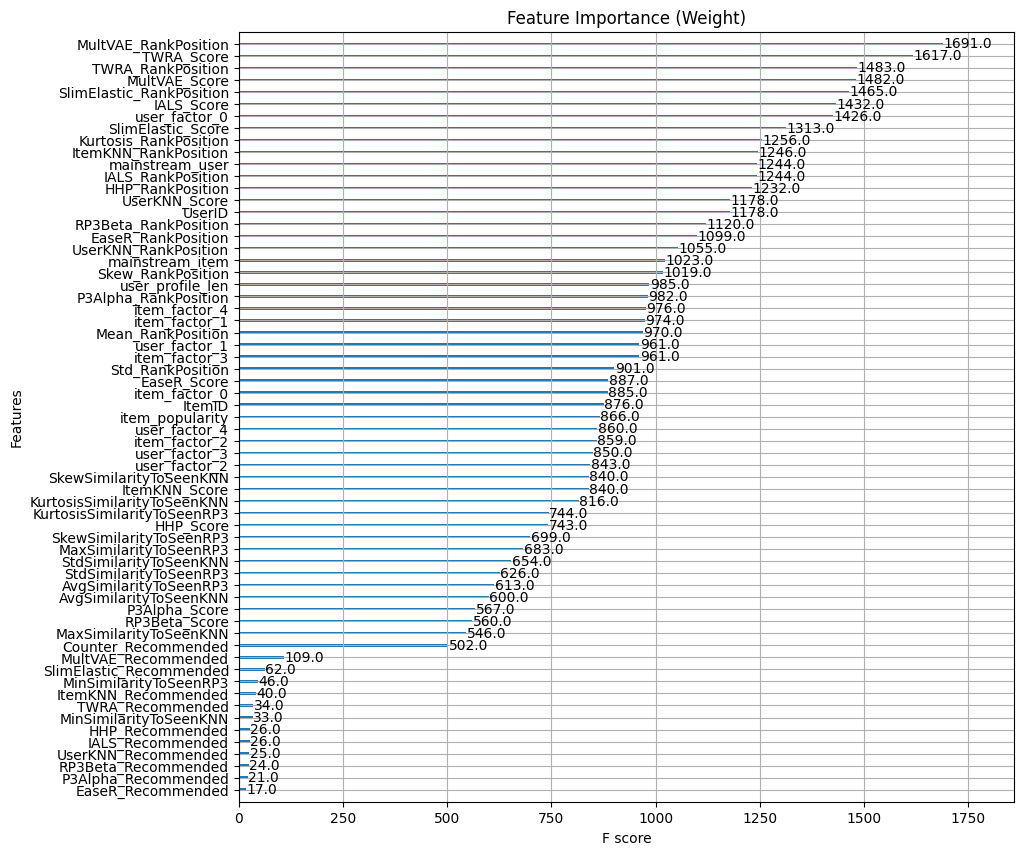

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Feature Importance (Weight)', ax=ax)

<Axes: title={'center': 'Feature Importance (Cover)'}, xlabel='F score', ylabel='Features'>

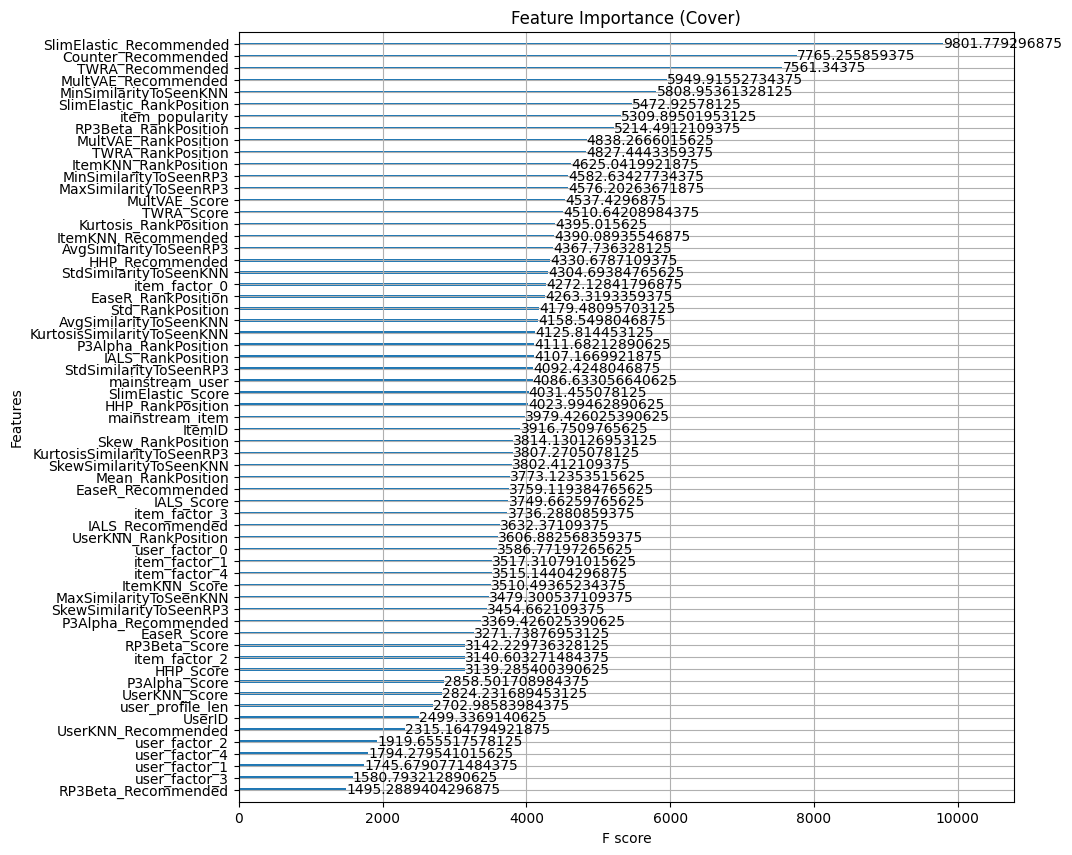

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='cover', title='Feature Importance (Cover)', ax=ax)

<Axes: title={'center': 'Feature Importance (Gain)'}, xlabel='F score', ylabel='Features'>

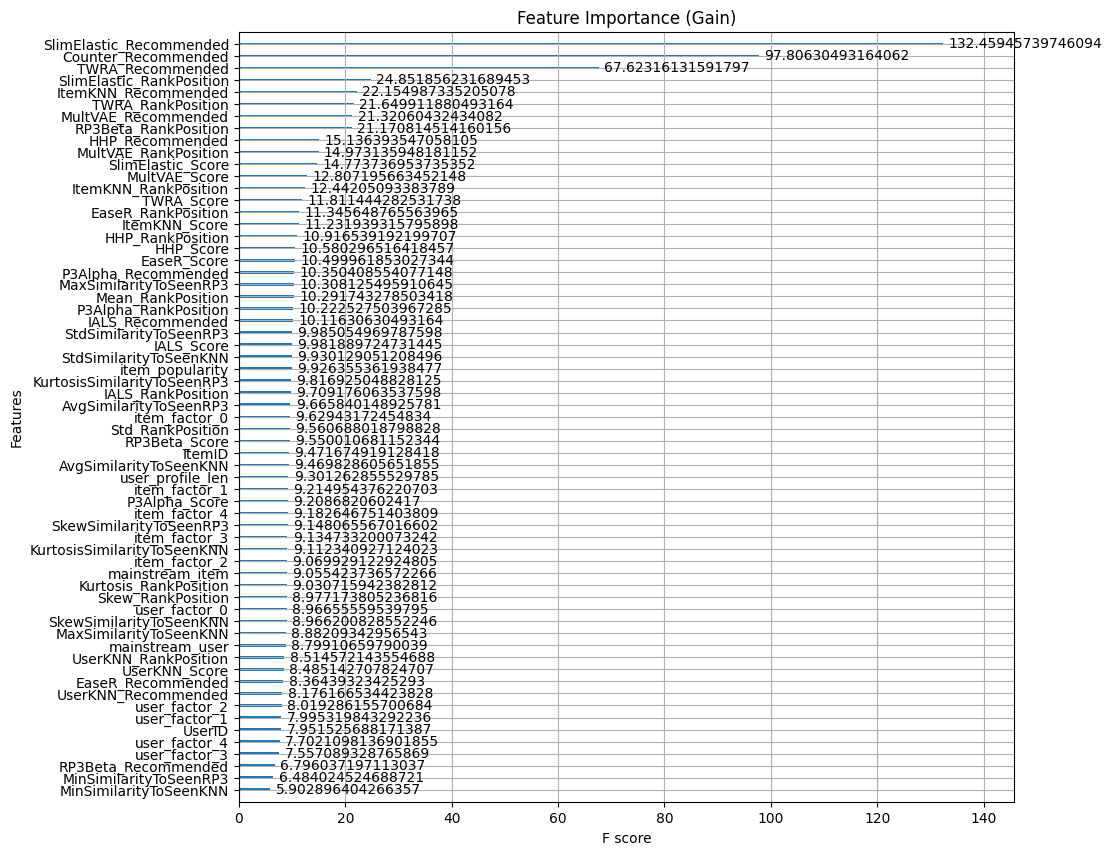

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='gain', title='Feature Importance (Gain)', ax=ax)

In [73]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

# recommender_pure_svd = PureSVDRecommender(URM_all)
# recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

# recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
# recommender_pure_svd_item.fit(**params_pure_svd_item)

# recommender_scaled_svd = ScaledPureSVDRecommender(URM_all)
# recommender_scaled_svd.fit(**params_scaled)

# recommender_nmf = NMFRecommender(URM_all)
# recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

# recommender_slim_bpr = SLIM_BPR_Python(URM_all)
# recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

recommender_vae = MultVAERecommender(URM_all)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_all')

recommender_hhp = HHPRecommender(URM_all)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_all)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_all)
# recommender_als.load_model('/kaggle/working/', 'als_all.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_all)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_all.zip')

recommender_rp3_recall = RP3betaRecommender(URM_all)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_all)
recommender_item_recall.fit(**params_item_knn)

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1795.77 column/sec. Elapsed time 12.44 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1265.21 column/sec. Elapsed time 10.29 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 3896.46 column/sec. Elapsed time 5.74 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity col

In [74]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
#     'NMF': recommender_nmf,
#     'PureSVD': recommender_pure_svd,
#     'ScaledSVD': recommender_scaled_svd,
#     'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
#     'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [75]:
cutoff = 50
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        prediction_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        prediction_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        prediction_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in prediction_dataframe.columns if col.endswith('_Recommended')]
prediction_dataframe['Counter_Recommended'] = prediction_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in prediction_dataframe.columns if col.endswith('_RankPosition')]
prediction_dataframe['Mean_RankPosition'] = prediction_dataframe[position_columns].mean(axis=1)
prediction_dataframe['Std_RankPosition'] = prediction_dataframe[position_columns].std(axis=1)
prediction_dataframe['Skew_RankPosition'] = prediction_dataframe[position_columns].skew(axis=1)
prediction_dataframe['Kurtosis_RankPosition'] = prediction_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
item_popularity = item_popularity / np.max(item_popularity)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
user_popularity = user_popularity / np.max(user_popularity)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_all.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
prediction_dataframe['mainstream_item'] = mainstream_item[prediction_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

prediction_dataframe = prediction_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
prediction_dataframe = prediction_dataframe.sort_values(by='UserID')

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

/tmp/ipykernel_19/3716254121.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/3716254121.py:74: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/tmp/ipykernel_19/3716254121.py:75: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,0.000000,22150.0,0.0,0.056352,116.0,0.0,0.000000,22150.0,...,0.161283,0.057152,-0.179342,-0.017935,0.058487,0.005573,0.000276,0.007795,-0.010629,-0.00153
52,0,1088,0.154091,32.0,0.0,0.023720,533.0,0.0,0.044536,64.0,...,0.011559,-0.010352,0.023728,0.026256,0.054180,0.005573,0.000276,0.007795,-0.010629,-0.00153
51,0,1082,0.257622,16.0,0.0,0.028504,397.0,0.0,0.088188,20.0,...,0.009403,-0.015196,0.006105,0.006968,-0.003826,0.005573,0.000276,0.007795,-0.010629,-0.00153
50,0,1067,0.000000,8334.0,0.0,0.062167,98.0,0.0,0.028730,174.0,...,0.006633,0.003640,0.012812,-0.006773,0.000987,0.005573,0.000276,0.007795,-0.010629,-0.00153
49,0,1056,0.148159,35.0,0.0,0.005110,4317.0,0.0,0.084663,23.0,...,0.002581,-0.001164,0.000101,-0.001671,0.001920,0.005573,0.000276,0.007795,-0.010629,-0.00153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140288,13023,562,0.115758,51.0,0.0,0.466899,15.0,0.0,0.000000,7076.0,...,0.016208,-0.027308,0.038129,0.034668,0.064529,0.009693,-0.007923,-0.000423,0.004501,0.02307
1140283,13023,407,0.000000,7162.0,0.0,0.358814,32.0,0.0,0.000000,7125.0,...,0.020133,-0.039630,0.018020,0.009480,0.061207,0.009693,-0.007923,-0.000423,0.004501,0.02307
1140279,13023,328,0.145361,40.0,0.0,0.491791,9.0,1.0,0.132055,39.0,...,0.021672,-0.033971,0.021338,0.030802,0.063427,0.009693,-0.007923,-0.000423,0.004501,0.02307
1140294,13023,798,0.167712,34.0,0.0,0.453557,18.0,0.0,0.135379,38.0,...,0.011918,-0.029146,0.021760,0.012844,0.062538,0.009693,-0.007923,-0.000423,0.004501,0.02307


In [76]:
recommender = XGBoostRerankerRecommender(URM_all, XGB_model, prediction_dataframe)

In [77]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_xgboost_only_best.csv', index=False)

,user_id,item_list
0,1,36 101 123 506 403 515 1546 694 977 52
1,2,1095 12 1522 47 196 50 2 102 359 8
2,3,59 259 857 239 536 956 4252 648 584 1281
3,4,249 28 50 7 139 5 171 146 254 314
4,5,1570 77 5138 131 1511 471 1220 170 95 4
